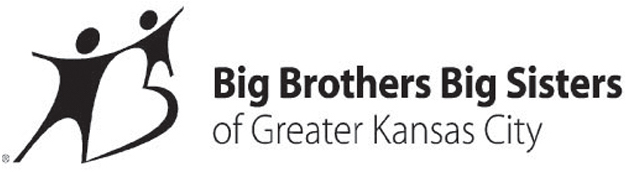

In [1]:
# load logo
from IPython.display import display, Image
p1 = '/Users/pieroferrante/Documents/Pics/bbbs_logo.jpg'
Image(filename=p1)

___
# Helping BBBS Build More Enduring Matches

This analysis seeks to use data visualization and predicitve modeling to explore and better understand what types of child and volunteer attributes yield more long-lasting matches between bigs and littles.

In [136]:
# turn warnings off
import warnings
warnings.filterwarnings('ignore')

# import modules
import pandas as pd
import numpy as np
from db import DB
import pymssql
from datetime import datetime
from ast import literal_eval
import phonenumbers as pn
from math import radians, cos, sin, asin, sqrt

# set plotting preferences
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.style.use('bmh')

# format notebook output
from IPython.display import HTML, Javascript, display
import IPython.core.display as di
display(Javascript("IPython.OutputArea.prototype._should_scroll=function(){return false;};"))
pd.set_option('display.max_columns', 1000)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.rcParams['figure.figsize'] = (16.0, 4.0)

# load autotime
#%load_ext autotime

<IPython.core.display.Javascript object>

In [3]:
# read date
df = pd.read_csv('/Users/pieroferrante/Downloads/match.csv')

# read zip/coordinates
zip_2_coords = pd.read_csv('/Users/pieroferrante/Downloads/zip_coords.txt', converters={'ZIP': str})

###############################################################################

# map values
MatchClosureType = {
    'Child/Family: Infraction of match rules/agency policies': 1,
    'Volunteer: Infraction of match rules/agency policies': 1,
    'Child/Family: Lost contact with volunteer/agency': 1,
    'Volunteer: Changed workplace/school partnership': 0,
    'Child/Family: Feels incompatible with volunteer': 1,
    'Volunteer: Feels incompatible with child/family': 1,
    'Agency: Concern with Volunteer re: child safety': 1,
    'Strong Relationship: Support No Longer Needed': 2,
    'Agency: Challenges with program/partnership': 2,
    'Match Successful: Support No Longer Needed': 2,
    'Child: Cust. Adult Unsupportive/Interfered': 1,
    'Volunteer: Lost contact with child/agency': 1,
    'Child/Family: Unrealistic expectations': 1,
    'Child (or Parent): Does Not Like Vol': 1,
    'Volunteer: Unrealistic expectations': 1,
    'Vol: Does Not Like Child or Parent': 1,
    'Child: Health or Behavior Problem': 0,
    'Child (or Parent): Other Reason': 2,
    'Child: Family structure changed': 0,
    'Child/Family: Time constraints': 1,
    'Child: Severity of challenges': 1,
    'Vol: Changed School or Site': 0,
    'Child: Changed school/site': 0,
    'Volunteer: Time constraint': 1,
    'Child: Lost interest': 1,
    'Volunteer: Deceased': 0,
    'Child/Family: Moved': 0,
    'Vol: Family Change': 0,
    'Vol: Lost Interest': 1,
    'Volunteer: Health': 0,
    'Vol: Other Reason': 2,
    'Child: Graduated': 0,
    'Volunteer: Moved': 0,
    'Child: Deceased': 0,
     np.nan: 2
}

# set label dictionary
label_lookup =  {0: 'Involuntary',
                 1: 'Voluntary',
                 2: 'Unknown'}

# map function
df['MatchClosureType'] = df['MatchClosurePrimaryReason'].map(lambda x: MatchClosureType[x])
df['MatchClosureTypeDesc'] = df['MatchClosureType'].map(lambda x: label_lookup[x])

# filter
df = df[(df['MatchClosureType']==0) | (df['MatchClosureType']==1)]

###############################################################################

# calc age diff
df['AgeDifference'] = df['VolAge'] - df['ChildAge']

###############################################################################

# build dictionary
k = zip_2_coords['ZIP'].tolist()
v = zip(zip_2_coords['LAT'].tolist(), zip_2_coords['LNG'].tolist())
d = {}
for idx, val in enumerate(v):
    d[k[idx]] = val

def haversine(x):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    try:
        cz = str(x['ChildZip'])
    except:
        cz = '00000'
    try:
        vz = str(x['VolZip'])
    except:
        vz = '00000'
    try:
        ez = str(int(x['VolEmployerZipCode']))
    except:
        ex = '00000'
    
    # get coordinates
    try:
        
        lat1 = d[cz][0]
        lon1 = d[cz][1]
        lat2 =  d[vz][0]
        lon2 = d[vz][1]

        # convert decimal degrees to radians 
        lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
        # haversine formula 
        dlon = lon2 - lon1 
        dlat = lat2 - lat1 
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * asin(sqrt(a)) 
        v_miles = (6367 * c) * 0.621371
        
    except:
        v_miles = np.nan
        
    try:
        lat1 = d[cz][0]
        lon1 = d[cz][1]
        lat3 =  d[ez][0]
        lon3 = d[ez][1]

        # convert decimal degrees to radians 
        lon1, lat1, lon3, lat3 = map(radians, [lon1, lat1, lon3, lat3])
        # haversine formula 
        dlon = lon3 - lon1 
        dlat = lat3 - lat1 
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat3) * sin(dlon/2)**2
        c = 2 * asin(sqrt(a)) 
        e_miles = (6367 * c) * 0.621371
        
    except:
        e_miles = np.nan
    
    return (v_miles, e_miles)

# distance between match and match work
df['distances'] = df.apply(haversine, axis=1)

# unpack tuple and add columns
new_col_list = ['VolDistance', 'VolEmployerDistance']
for n,col in enumerate(new_col_list):
    df[col] = df['distances'].apply(lambda location: location[n])
df = df.drop('distances',axis=1)

###############################################################################

# identify top 10 matchers
top_matchers = df['MatchReportSources'].value_counts()[:10].index.tolist()
df['MatchReportSource'] = df['MatchReportSources'].map(lambda x: x if x in top_matchers else 'Not Top 10')
df = df.drop('MatchReportSources',axis=1)

# identify top 10 matchers
top_matchers = df['VolReferralSource'].value_counts()[:10].index.tolist()
df['VolReferralSource'] = df['VolReferralSource'].map(lambda x: x if x in top_matchers else 'Not Top 10')

###############################################################################

# get match month/quarter
df['MatchCloseDate'] = pd.to_datetime(df['MatchCloseDate'])
df['MatchQuarter'] = df['MatchCloseDate'].map(lambda x: x.quarter)
df['MatchMonth'] = df['MatchCloseDate'].map(lambda x: x.month)

###############################################################################

# fill in missing value(s)
df['CouplesMatch'].fillna('No', inplace=True)
df['IncarceratedParent'].fillna('Unknown', inplace=True)

###############################################################################

to_drop = ['UserName',
           'TimeInQueue',
           'PendingMatchDate',
           'MatchOpenDate',
           'MatchCloseDate',
           'MatchClosureReasons',
           'MatchClosureDetail',
           'MatchClosurePrimaryReason',
           'MatchClosureSecondaryReason',
           'CouplesSecondary',
           'ChildNationality',
           'ChildDOB',
           'ChildAddress1',
           'ChildCity',
           'ChildCounty',
           'ChildState',
           'VolNationality',
           'VolDOB',
           'VolAddress1',
           'VolCity',
           'VolCounty',
           'VolState',
           'VolEmployerState',
           'VolEmploymentLengthYears',
           'VolZip',
           'ChildZip',
           'VolEmployerZipCode',
           'CouplesPrimary']

for col in to_drop:
    del df[col]

###############################################################################

# fill missing string values
for col in list(df):
    if df[col].dtype == 'object':
        df[col].fillna('Unknown', inplace=True)
        
###############################################################################

# replace values
df['CouplesMatch'] = df['CouplesMatch'].str.replace('Y', 'Yes')
#df = df.replace('Yes', 1)
#df = df.replace('No', 0)

###############################################################################

# move to first column
temp = df['MatchClosureType']
df.drop(labels=['MatchClosureType'], axis=1, inplace = True)
df.insert(0, 'MatchClosureType', temp)

###############################################################################

# view data
#print df.shape
#df.head()

___
## How many matches were terminated voluntarily versus involuntarily?

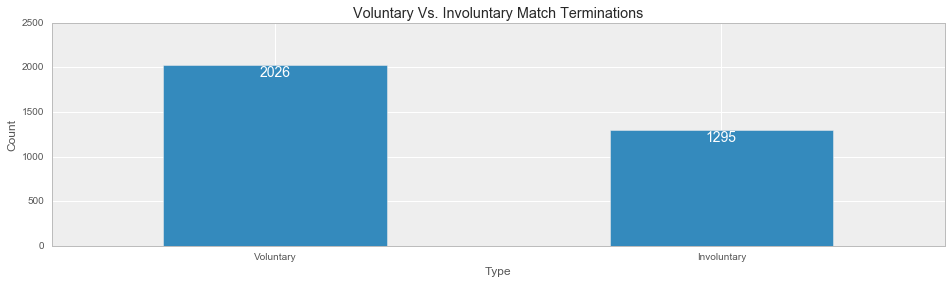

In [9]:
# get value counts
temp = df['MatchClosureTypeDesc'].value_counts()

# label helper function
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x()+rect.get_width()/2.0, height - 0.3, '%0.0f'%height,
              ha='center', va='top', fontsize=14, color='w')

# plot
ax = temp.plot(kind='bar', rot=0)
autolabel(ax.patches)
ax.set_xlabel('Type')
ax.set_ylabel('Count')
plt.title('Voluntary Vs. Involuntary Match Terminations')
#labels = [item.get_text() for item in ax.get_xticklabels()]
#labels = [label_lookup[int(label)] for label in labels]
#ax.set_xticklabels(labels, rotation=0)
plt.show()

___
## What are some statistics on these terminations with respect to match length?

In [10]:
# filter
temp = df[(df['MatchClosureType']==0) | 
          (df['MatchClosureType']==1)]

# get descriptive stats
temp = temp.groupby(['MatchClosureTypeDesc'], as_index=False)['MatchLength'].describe()

# set index
temp.index = ['Voluntary', 'Involuntary']

# filter
#temp = temp[['mean', 'std', '25%', '50%','75%']]

# view stats
temp.T

,Voluntary,Involuntary
count,1295.000,2026.000
mean,33.887,20.473
std,29.122,19.421
min,0.300,0.000
25%,12.450,7.100
50%,24.800,13.350
75%,47.050,27.200
max,149.600,118.600


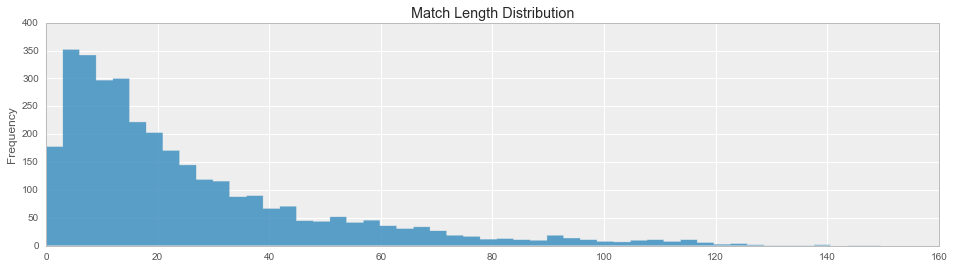

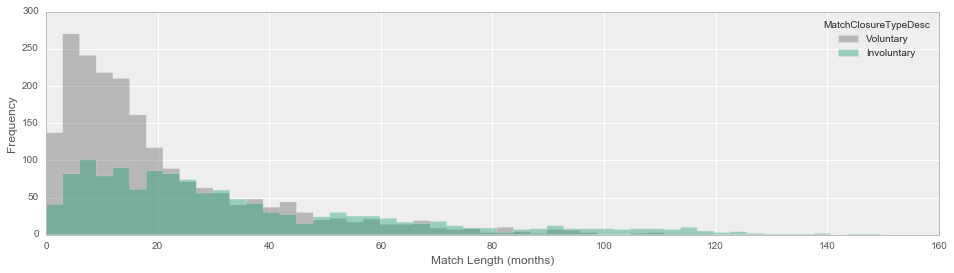

In [13]:
# filter
temp = df[(df['MatchClosureType']==0) | 
          (df['MatchClosureType']==1)]['MatchLength']

# plot
ax = temp.plot(kind='hist', histtype='stepfilled', alpha=0.8, bins=50)
ax.set_xlabel('')
ax.set_ylabel('Frequency')
plt.title('Match Length Distribution')
plt.show()

###############################################################################

# filter
temp = df[(df['MatchClosureType']==0) | 
          (df['MatchClosureType']==1)]

# reset index
temp = temp.reset_index()

# pivot
temp = pd.pivot_table(data=temp,
                      values='MatchLength',
                      index='index',
                      columns='MatchClosureTypeDesc',
                      fill_value=np.nan)

# filter
temp = temp[['Voluntary', 'Involuntary']]

# plot
ax = temp.plot.hist(bins=50, histtype='stepfilled', stacked=False, alpha=0.4, cmap='Dark2_r')
ax.set_xlabel('Match Length (months)')
ax.set_ylabel('Frequency')
plt.show()

___
## Are there any readily observable bivariate relationships among continuous variables?

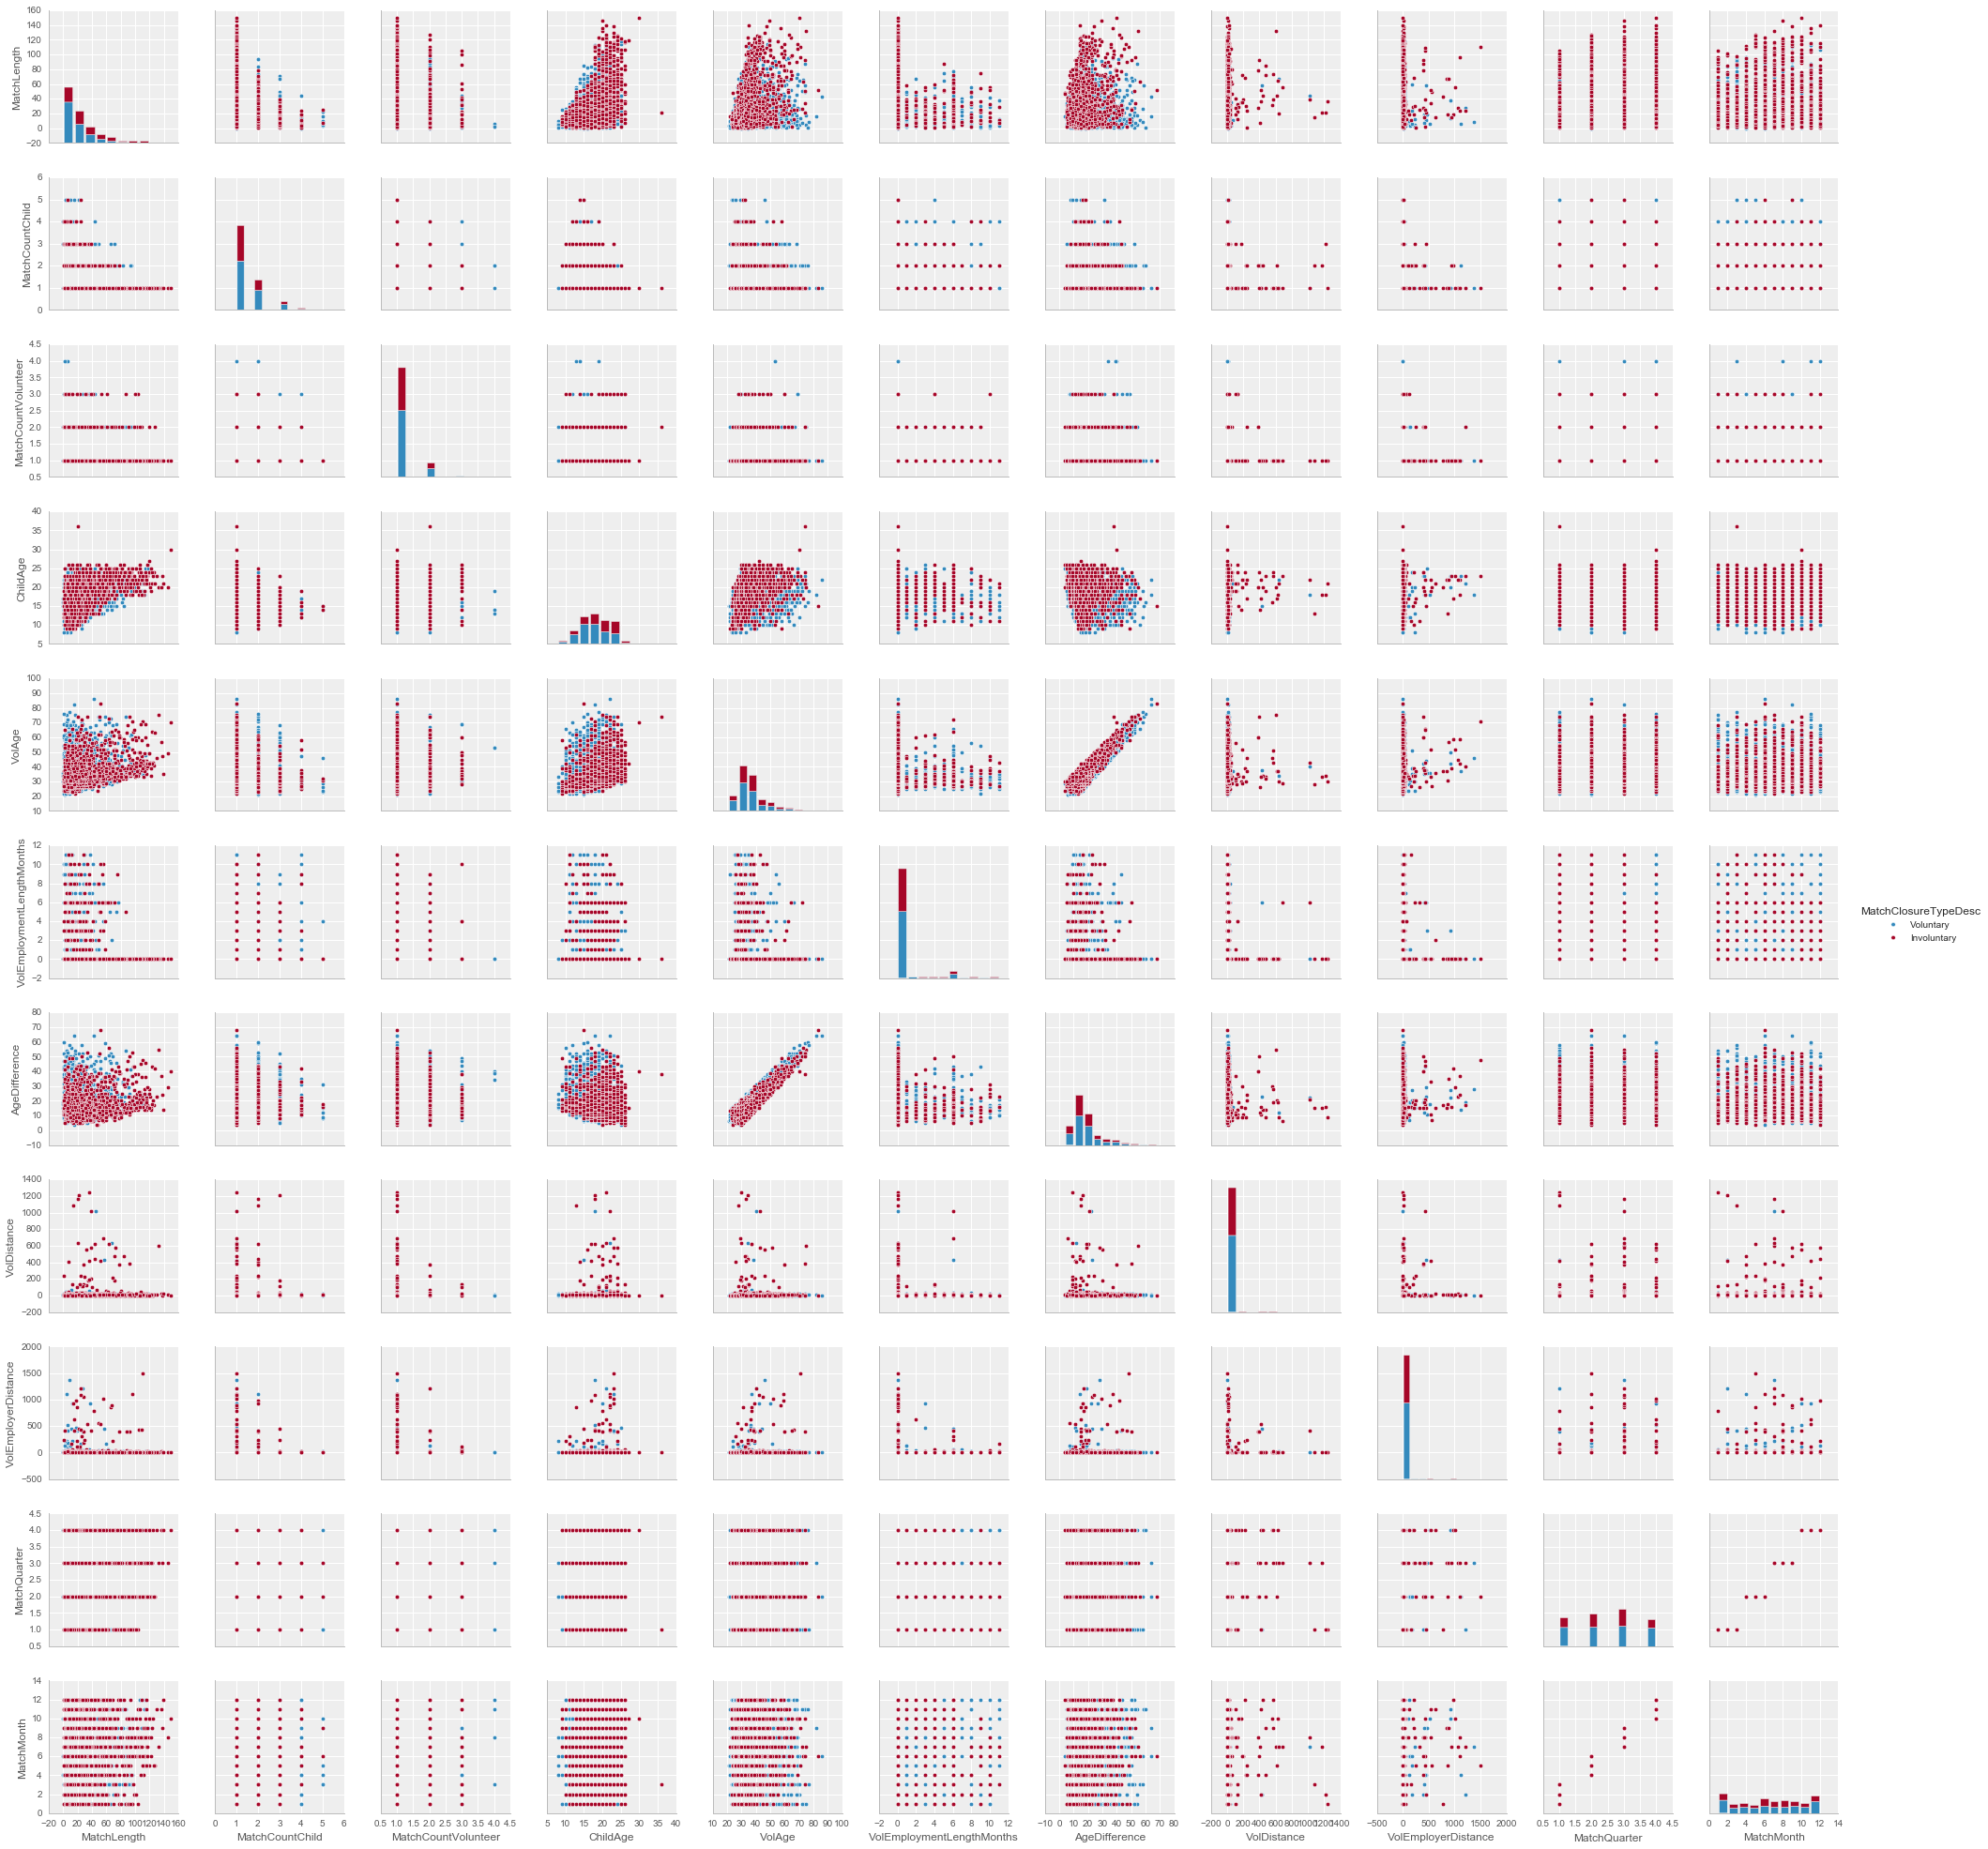

In [5]:
# filter
temp = df[(df['MatchClosureType']==0) | 
          (df['MatchClosureType']==1)]

# fill missing values
temp.fillna(0, inplace=True)

# set features
features = df.describe().columns.tolist()
features.remove('MatchClosureType')

# plot
g = sns.pairplot(temp, 
                 hue='MatchClosureTypeDesc', 
                 hue_order=None, 
                 palette=None, 
                 vars=features, 
                 kind='scatter', 
                 diag_kind='hist', 
                 markers=None, 
                 size=2.5, 
                 aspect=1, 
                 dropna=True, 
                 plot_kws=None, 
                 diag_kws=None, 
                 grid_kws=None)
plt.show()

___
## Are there linear relationships?

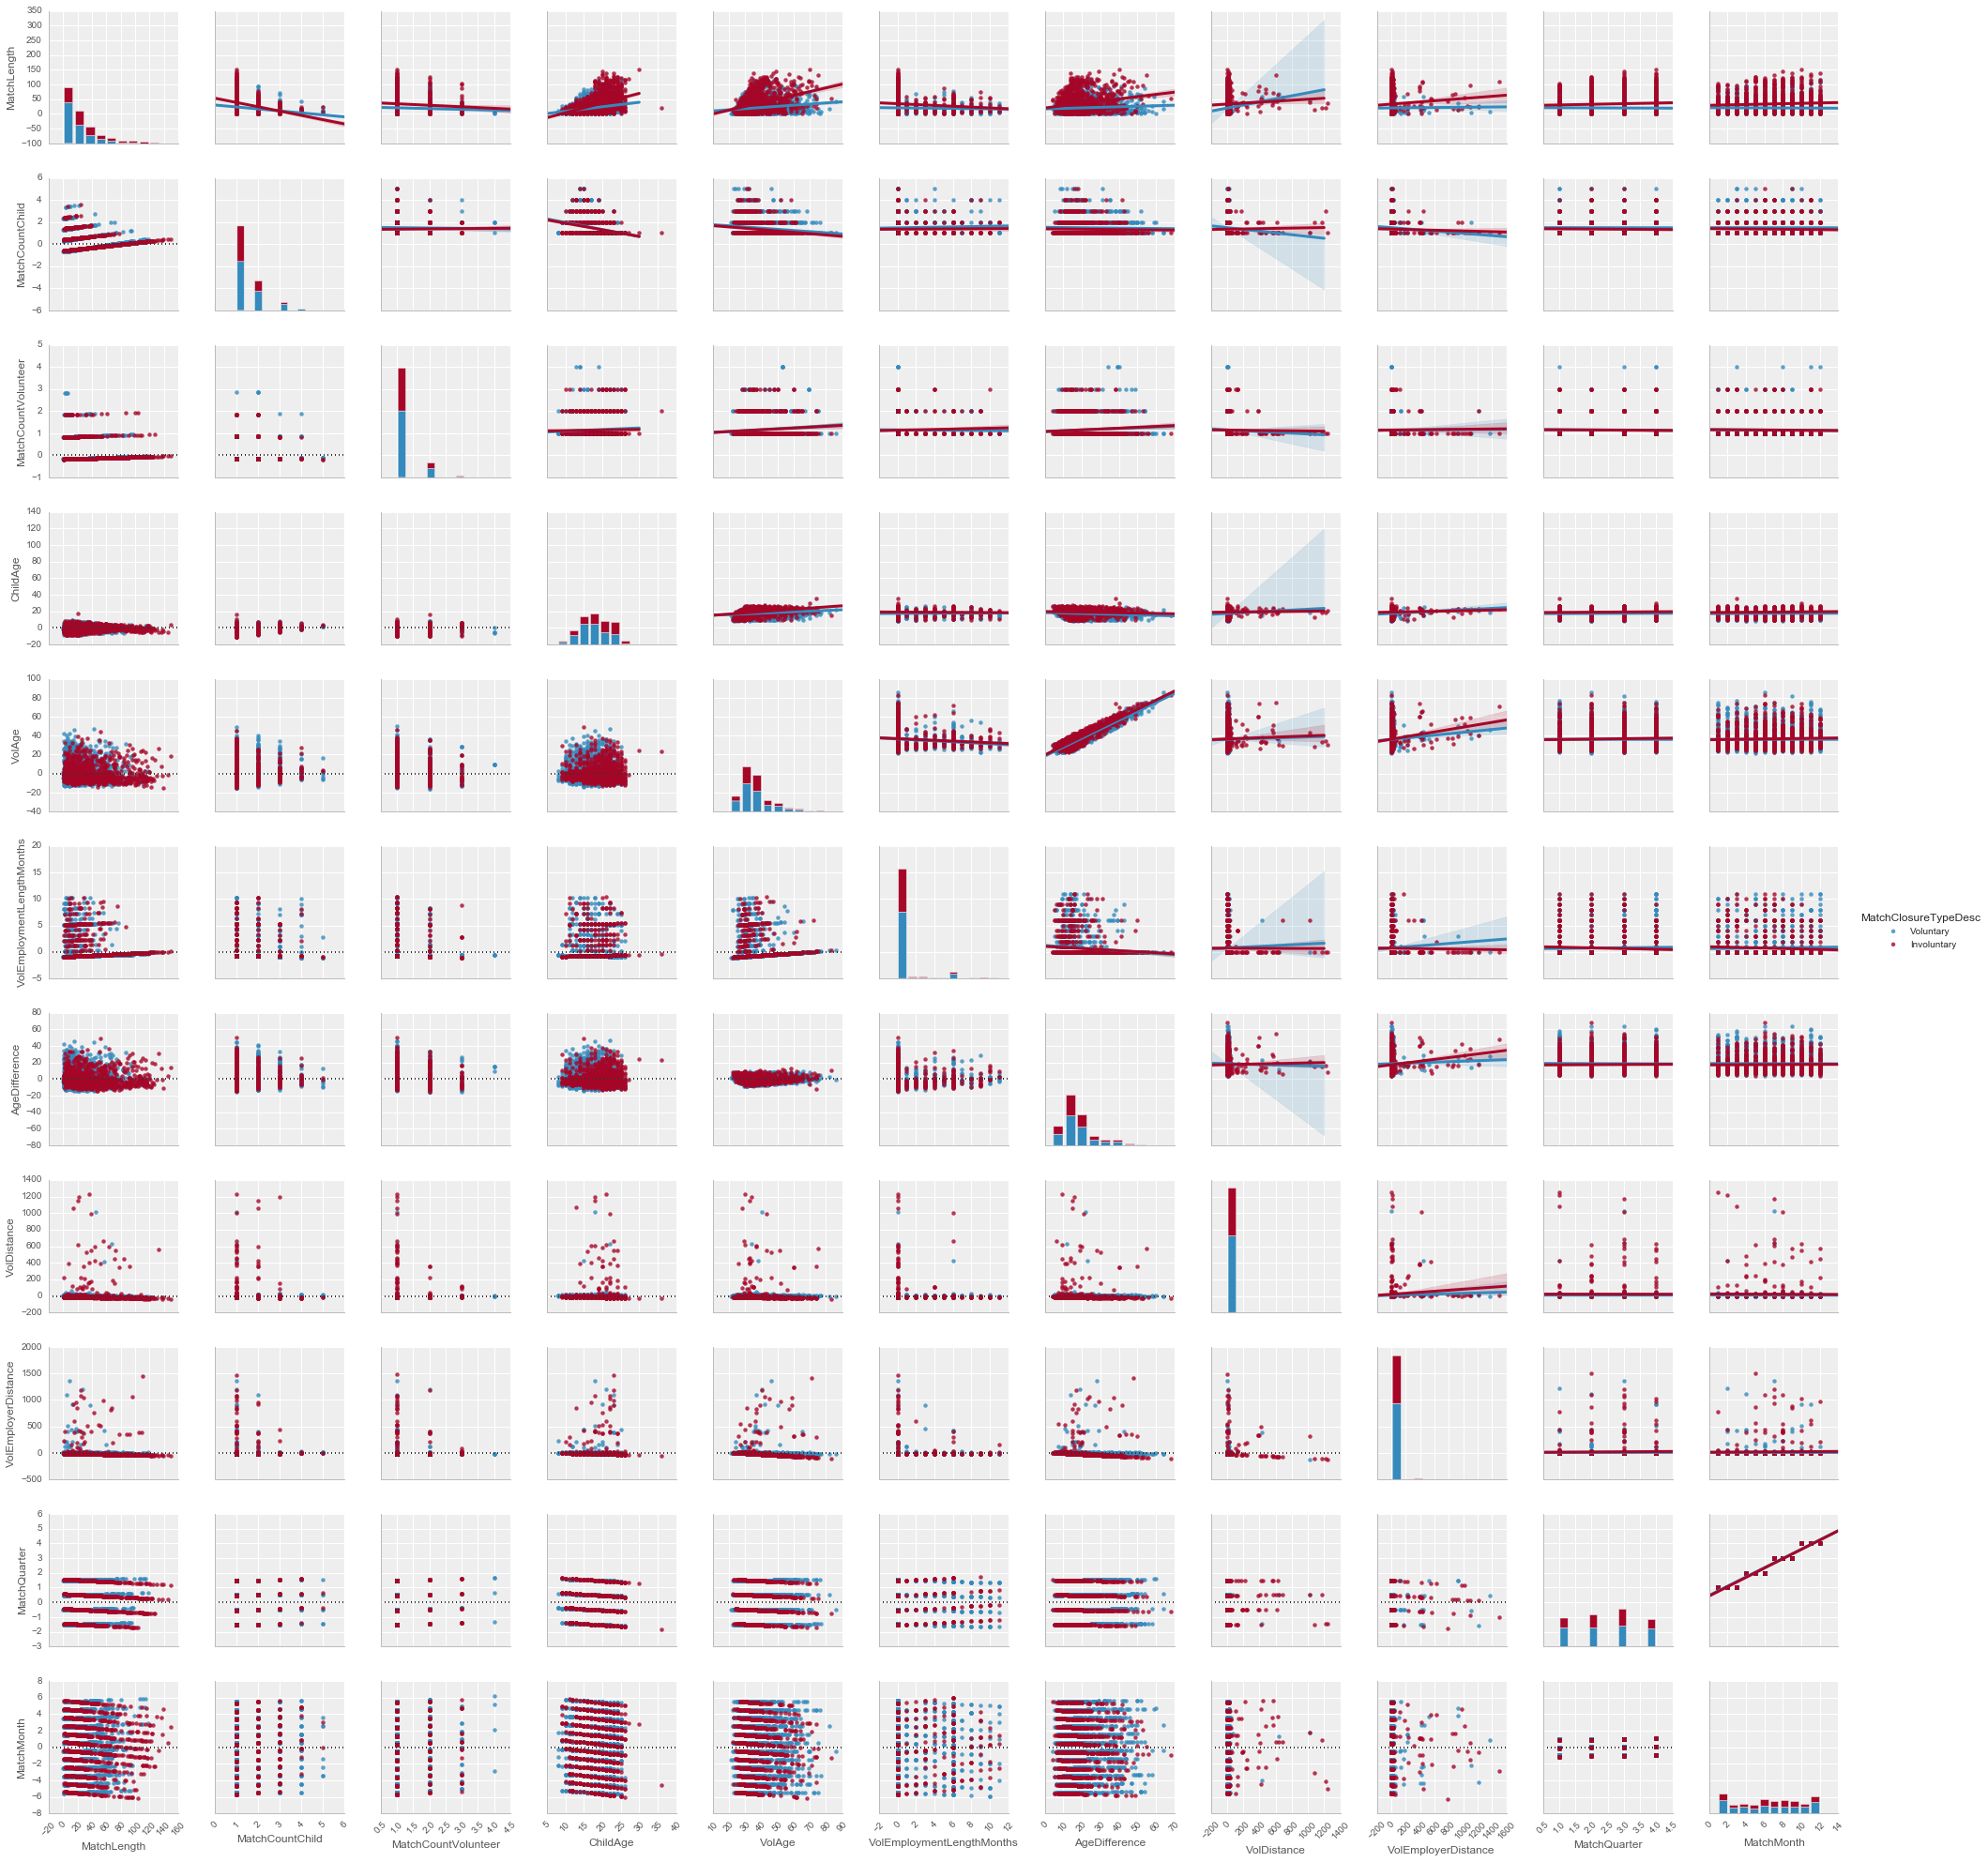

In [6]:
# add column
features.append('MatchClosureTypeDesc')

# plot
g = sns.PairGrid(temp[features], hue='MatchClosureTypeDesc')  
g.map_upper(sns.regplot)  
g.map_lower(sns.residplot)  
g.map_diag(plt.hist)  
for ax in g.axes.flat:  
    plt.setp(ax.get_xticklabels(), rotation=45)
g.add_legend()  
g.set(alpha=0.5)  
plt.show()

In [15]:
# # filter
# temp = df[(df['MatchClosureType']==0) | 
#           (df['MatchClosureType']==1)]

# # filter
# col = 'VolDistance'
# temp = temp[np.abs(temp[col]-temp[col].mean())<=(2*temp[col].std())]

# # filter
# t1 = temp[temp['MatchClosureType']==0]
# t2 = temp[temp['MatchClosureType']==1]

# # plot
# ax = t1.plot.scatter(x='VolDistance', 
#                      y='MatchLength', 
#                      color='Blue', 
#                      label='Involuntary', 
#                      alpha=0.2, 
#                      figsize=(10,7))
# t2.plot.scatter(x='VolDistance', 
#                 y='MatchLength', 
#                 color='Red', 
#                 label='Voluntary', 
#                 ax=ax, 
#                 alpha=0.1)
# plt.show()

In [16]:
# # filter
# temp = df[(df['MatchClosureType']==0) | 
#           (df['MatchClosureType']==1)]

# temp.groupby(['MatchClosureType'], as_index=False)['VolDistance'].describe()

___
## Are there any notable patterns concerning ethnicity matches? 

In [89]:
t2

,American Indian or Alaska Native,Asian,Black,Hispanic,Multi-Race (None of the above),Multi-race (Asian & White),Multi-race (Black & White),Multi-race (Hispanic & Asian),Multi-race (Hispanic & White),Some Other Race,White
ChildEthnicity,,,,,,,,,,,
American Indian or Alaska Native,nan,42.800,nan,nan,nan,nan,nan,nan,nan,nan,94.200
Asian,nan,50.600,23.700,nan,nan,73.000,nan,nan,nan,39.500,28.240
Black,18.000,25.711,31.240,22.656,nan,7.400,3.900,0.800,19.700,30.200,30.967
Hispanic,nan,29.450,22.225,37.654,17.550,nan,nan,nan,nan,16.067,31.998
Multi-Race (None of the above),nan,nan,nan,nan,85.100,nan,nan,nan,nan,nan,88.950
Multi-race (Asian & White),nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,10.000
Multi-race (Black & Hispanic),nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,23.650
Multi-race (Black & White),nan,nan,29.733,22.000,nan,nan,nan,nan,nan,nan,19.005
Multi-race (Hispanic & White),nan,nan,nan,21.600,nan,nan,nan,nan,nan,nan,22.169


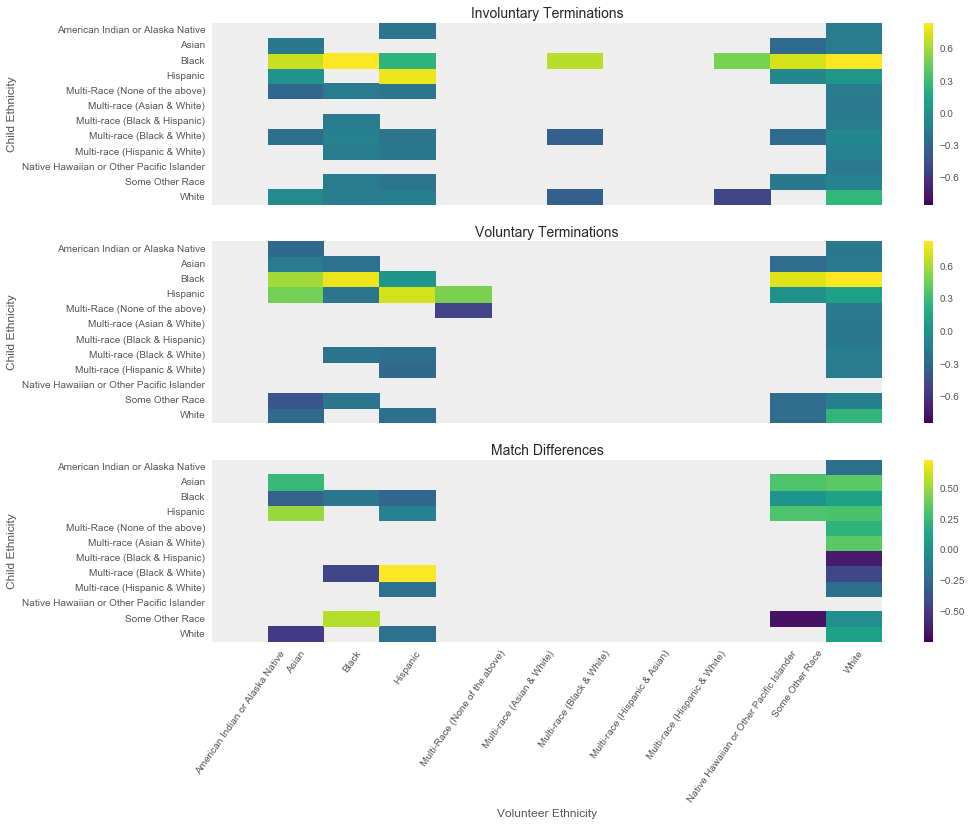

In [135]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# setup grid
plt.figure(figsize=(15, 15))
ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
ax2 = plt.subplot2grid((4,4), (1, 0), colspan=4)
ax3 = plt.subplot2grid((4,4), (2, 0), colspan=4)

###############################################################################

# pivot
temp = pd.pivot_table(data=df,
                      values='MatchLength',
                      index='ChildEthnicity',
                      columns='VolEthnicity',
                      aggfunc=np.size,
                      fill_value=np.nan)

# create master dataframe
t0 = pd.DataFrame(columns=temp.columns.tolist(),index=temp.index)
t0 = t0.astype(float)
t0.sort_index(axis=1, inplace=True)

###############################################################################

# filter
temp = df[df['MatchClosureType']==1]

# pivot
temp = pd.pivot_table(data=temp,
                      values='MatchLength',
                      index='ChildEthnicity',
                      columns='VolEthnicity',
                      aggfunc=np.size,
                      fill_value=np.nan)

# merge
tm = t0
for col in list(tm):
    if col in list(temp):
        del tm[col]
temp = pd.merge(tm, temp, how='left', left_index=True, right_index=True)

# copy
temp.sort_index(axis=1, inplace=True)
t1 = temp
temp = (temp - temp.mean()) / (temp.max() - temp.min())
#temp = (temp - temp.mean().mean()) / (temp.max().max() - temp.min().min())

# plot
plt.rcParams['figure.figsize'] = (15.0, 3.0)
ax = sns.heatmap(temp, cmap='viridis', ax=ax1,  fmt='g') # linewidths=.5, linecolor='black'
ax.set_xlabel('')
ax.set_ylabel('Child Ethnicity')
#labels = [item.get_text() for item in ax.get_xticklabels()]
#labels = [label_lookup[int(label)] for label in labels]
ax.set_xticklabels([], rotation=0)
#plt.title('Involuntary Match Average Duration')
ax1.set_title('Involuntary Terminations', fontsize=14)
plt.yticks(rotation=360)
plt.xticks(rotation=45)

###############################################################################

# filter
temp = df[df['MatchClosureType']==0]

# pviot
temp = pd.pivot_table(data=temp,
                      values='MatchLength',
                      index='ChildEthnicity',
                      columns='VolEthnicity',
                      aggfunc=np.size,
                      fill_value=np.nan)

# merge
tm = t0
for col in list(tm):
    if col in list(temp):
        del tm[col]
temp = pd.merge(tm, temp, how='left', left_index=True, right_index=True)

# add column
temp['Native Hawaiian or Other Pacific Islander'] = np.nan

# copy
temp.sort_index(axis=1, inplace=True)
t2 = temp
temp = (temp - temp.mean()) / (temp.max() - temp.min())
#temp = (temp - temp.mean().mean()) / (temp.max().max() - temp.min().min())

# plot
plt.rcParams['figure.figsize'] = (15.0, 3.0)
ax = sns.heatmap(temp, cmap='viridis', ax=ax2,  fmt='g') # linewidths=.5, linecolor='black'
ax.set_xlabel('')
ax.set_ylabel('Child Ethnicity')
ax.set_xticklabels([], rotation=0)
#plt.title('Voluntary Match Average Duration')
ax2.set_title('Voluntary Terminations', fontsize=14)
plt.yticks(rotation=360)
plt.xticks(rotation=45)

###############################################################################

# calcultae difference
temp = t2 / (t1 + t2)
temp = (temp - temp.mean()) / (temp.max() - temp.min())
#temp = (temp - temp.mean().mean()) / (temp.max().max() - temp.min().min())

# plot
plt.rcParams['figure.figsize'] = (15.0, 3.0)
ax = sns.heatmap(temp, cmap='viridis', ax=ax3,  fmt='g') # linewidths=.5, linecolor='black'
ax.set_xlabel('Volunteer Ethnicity')
ax.set_ylabel('Child Ethnicity')
#plt.title('Match Average Duration Difference')
ax3.set_title('Match Differences', fontsize=14)
plt.yticks(rotation=360)
plt.xticks(rotation=55)
plt.show()

In [469]:
# drop column
df = df.drop('MatchClosureTypeDesc',axis=1)
df2 = df.copy(deep=True)

In [389]:
df = df2
del df['MatchLength']

In [381]:
# remove outliers
# for col in df[continuous_features]:
#     # keep only the ones that are within +3 to -3 standard deviations in the column
#     df = df[np.abs(df[col]-df[col].mean())<=(2*df[col].std())] 
# print df.shape

In [382]:
# def ideal_percentile(col, pct):
#     for p in range(pct,0,-1):
#         try:
#             percentiles = pd.qcut(col, p)
#             return percentiles
#             break
#         except:
#             pass

# print df.shape
# for col in list(df.ix[:, 1:]):
#     new = ideal_percentile(df[col], 10)
#     #del df[col]
#     df = pd.concat([df, new], axis=1)
#     df[col] = df[col].apply(lambda x: x[1:-1].replace(', ', '_') if pd.isnull(x)==False else x)
# print df.shape
# for f in _features: categorical_features.append(f)
# df.head()

In [471]:
# identify categorical features
categorical_features = []
for col in list(df):
    if df[col].dtype == 'object':
        categorical_features.append(col)
print df.shape
for col in df[categorical_features]:
    df = pd.concat([df, pd.get_dummies(df[col], prefix=col, dummy_na=True)], axis=1)
    del df[col]
print df.shape
df.head()

(3321, 26)
(3321, 156)


,MatchLength,MatchCountChild,MatchCountVolunteer,ChildAge,VolAge,VolEmploymentLengthMonths,AgeDifference,VolDistance,VolEmployerDistance,MatchQuarter,MatchMonth,CouplesMatch_No,CouplesMatch_Yes,CouplesMatch_nan,ChildGender_F,ChildGender_M,ChildGender_nan,ChildEthnicity_American Indian or Alaska Native,ChildEthnicity_Asian,ChildEthnicity_Black,ChildEthnicity_Hispanic,ChildEthnicity_Multi-Race (None of the above),ChildEthnicity_Multi-race (Asian & White),ChildEthnicity_Multi-race (Black & Hispanic),ChildEthnicity_Multi-race (Black & White),ChildEthnicity_Multi-race (Hispanic & White),ChildEthnicity_Native Hawaiian or Other Pacific Islander,ChildEthnicity_Some Other Race,ChildEthnicity_White,ChildEthnicity_nan,IncarceratedParent_No,IncarceratedParent_Unknown,IncarceratedParent_Yes,IncarceratedParent_nan,AdultChildRelationship_Aunt,AdultChildRelationship_Father,AdultChildRelationship_Foster Parent,AdultChildRelationship_GrandFather,AdultChildRelationship_GrandMother,AdultChildRelationship_Mother,AdultChildRelationship_Non-Relative: Other,AdultChildRelationship_Relative: Other,AdultChildRelationship_Self-Emancipated Minor,AdultChildRelationship_Social Worker-Case Mgr,AdultChildRelationship_Step-Father,AdultChildRelationship_Step-Mother,AdultChildRelationship_Uncle,AdultChildRelationship_nan,ChildLivingSituation_Foster Home,ChildLivingSituation_Grandparents,ChildLivingSituation_Group Home,ChildLivingSituation_Institution,ChildLivingSituation_One Parent: Female,ChildLivingSituation_One Parent: Male,ChildLivingSituation_Other Relative,ChildLivingSituation_Other/Unknown,ChildLivingSituation_Two Fathers,ChildLivingSituation_Two Mothers,ChildLivingSituation_Two Parent,ChildLivingSituation_nan,"ChildHouseholdIncome_$10,000 to $14,999","ChildHouseholdIncome_$100,000 to $124,999","ChildHouseholdIncome_$15,000 to $19,999","ChildHouseholdIncome_$20,000 to $24,999","ChildHouseholdIncome_$25,000 to $29,999","ChildHouseholdIncome_$30,000 to $34,999","ChildHouseholdIncome_$35,000 to $39,999","ChildHouseholdIncome_$40,000 to $44,999","ChildHouseholdIncome_$45,000 to $49,999","ChildHouseholdIncome_$50,000 to $59,999","ChildHouseholdIncome_$60,000 to $74,999","ChildHouseholdIncome_$75,000 to $99,999","ChildHouseholdIncome_Less than $10,000",ChildHouseholdIncome_Unknown,ChildHouseholdIncome_nan,ChildFreeReducedlunch_No,ChildFreeReducedlunch_Unknown,ChildFreeReducedlunch_Yes,ChildFreeReducedlunch_nan,ChildReferralType_BBBS Board/Staff,ChildReferralType_Faith Organization,ChildReferralType_Foster Home,ChildReferralType_Media,ChildReferralType_Neighbor/Friend,ChildReferralType_Relative,ChildReferralType_School,ChildReferralType_Self,ChildReferralType_Service Organization,ChildReferralType_Special Event,ChildReferralType_Therapist/Counselor,ChildReferralType_Web Link,ChildReferralType_Workplace Partner/Business,ChildReferralType_nan,VolGender_F,VolGender_M,VolGender_nan,VolEthnicity_American Indian or Alaska Native,VolEthnicity_Asian,VolEthnicity_Black,VolEthnicity_Hispanic,VolEthnicity_Multi-Race (None of the above),VolEthnicity_Multi-race (Asian & White),VolEthnicity_Multi-race (Black & White),VolEthnicity_Multi-race (Hispanic & Asian),VolEthnicity_Multi-race (Hispanic & White),VolEthnicity_Native Hawaiian or Other Pacific Islander,VolEthnicity_Some Other Race,VolEthnicity_White,VolEthnicity_nan,VolMaritalStatus_Divorced,VolMaritalStatus_Domestic Partner,VolMaritalStatus_Living w/ Significant Other,VolMaritalStatus_Married,VolMaritalStatus_Separated,VolMaritalStatus_Single,VolMaritalStatus_Unknown,VolMaritalStatus_nan,VolReferralSource_BBBS National Site,VolReferralSource_Boulevard Event,VolReferralSource_Brochure,VolReferralSource_Cerner,VolReferralSource_Former Big,VolReferralSource_Local Website,VolReferralSource_Not Top 10,VolReferralSource_Other,VolReferralSource_Radio,VolReferralSource_TV,VolReferralSource_UMKC,VolReferralSource_nan,VolReferralType_BBBS Board/Staff,VolReferralType_College Partner,VolReferralType_Faith Organization,VolReferralType

In [472]:
# impute
for col in list(df):
    if df[col].dtype == 'float64' or df[col].dtype == 'int64':
        if len(df[df[col].isnull()]) > 0:
            mode = df[col].value_counts().index[0]
            df[col].fillna(mode, inplace=True)

In [473]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# remove low variance features
sel = VarianceThreshold()
X = sel.fit_transform(df.ix[:,1:].values)
y = df.ix[:, 0]

In [474]:
# standardize data
scaler = StandardScaler()
X = scaler.fit_transform(X) 

In [475]:
# split dataset
y = df.ix[:,0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
print X_train.shape
print y_train.shape
print X_test.shape
print y_test.shape

(1992, 140)
(1992,)
(1329, 140)
(1329,)


In [435]:
from sklearn.linear_model import LogisticRegression

# instantiate model
clf = LogisticRegression(penalty='l2', 
                        dual=False, 
                        tol=0.0001, 
                        C=1.0, 
                        fit_intercept=True, 
                        intercept_scaling=1, 
                        class_weight=None, 
                        random_state=None, 
                        solver='liblinear', 
                        max_iter=100, 
                        multi_class='ovr', 
                        verbose=0, 
                        warm_start=False, 
                        n_jobs=-1)
# train model
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [436]:
# make predictions
clf_score = clf.score(X_test, y_test)
clf_preds= clf.predict(X_test)
try:
    clf_probs = clf.predict_proba(X_test)[:,1]
    clf_probs_2 = clf.predict_proba(X)[:,1]
    clf_probs_out = clf.predict_proba(X_new)[:,1]
except:
    pass

accuracy = 0.610233258089
brier = 0.245036837702
             precision    recall  f1-score   support

          0       0.52      0.35      0.41       529
          1       0.64      0.79      0.71       800

avg / total       0.59      0.61      0.59      1329



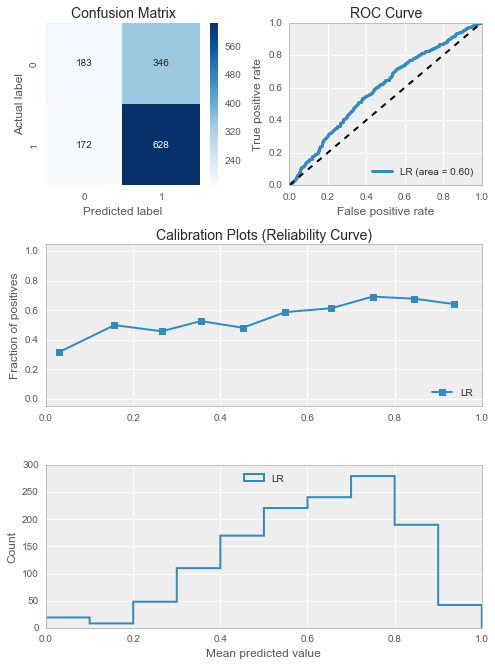

In [437]:
from sklearn import metrics
from seaborn import heatmap
from sklearn.calibration import calibration_curve

def clf_eval_viz(clf_name, y_test, clf_preds, clf_probs):
    
    # generate classification report
    print("accuracy = " + str(metrics.accuracy_score(y_test, clf_preds, normalize=True)))
    #clf_preds_2 = pd.Series(clf_probs).map(lambda r: 0 if r < 0.50 else 1)
    #print("recall = " + str(metrics.recall_score(y_test, clf_preds_2, pos_label=1, average='binary')))
    print("brier = " + str(metrics.brier_score_loss(y_test, clf_probs, pos_label=y.max())))
    print(metrics.classification_report(y_test, clf_preds))
    
    # create subplot
    plt.figure(figsize=(7, 12))
    ax1 = plt.subplot2grid((4,4), (0,0), colspan=2)
    ax2 = plt.subplot2grid((4,4), (0,2), colspan=2)
    ax3 = plt.subplot2grid((4,4), (1, 0), colspan=4)
    ax4 = plt.subplot2grid((4,4), (2, 0), colspan=4)
    
    # create confusion matrix
    ax1.set_title("Confusion Matrix", fontsize=14)
    cm = metrics.confusion_matrix(y_test, clf_preds)
    heatmap(cm, annot=True, fmt='', cmap='Blues', ax=ax1)
    ax1.set_xlabel('Predicted label')
    ax1.set_ylabel('Actual label')
    
    # create roc curve
    ax2.set_title("ROC Curve", fontsize=14)
    fpr, tpr, _ = metrics.roc_curve(y_test, clf_probs)
    area = metrics.auc(fpr, tpr)
    ax2.plot(fpr, tpr, label=clf_name+' (area = %0.2f)' % area, linewidth=3)
    ax2.plot([0, 1], [0, 1], 'k--')
    ax2.set_xlabel('False positive rate')
    ax2.set_ylabel('True positive rate')
    ax2.legend(loc="lower right")
    
    # calculate fraction of positives and mean predicted value
    fop, mpv = calibration_curve(y_test, clf_probs, n_bins=10)
    
    # create calibration plot 1
    ax3.plot(mpv, fop, "s-", label="%s" % (clf_name, ))
    ax3.set_ylabel("Fraction of positives")
    ax3.set_ylim([-0.05, 1.05])
    ax3.legend(loc="lower right")
    ax3.set_title('Calibration Plots (Reliability Curve)', fontsize=14)

    # create calibration plot 2
    ax4.hist(clf_probs, range=(0, 1), bins=10, label=clf_name, histtype="step", lw=2)
    ax4.set_xlabel("Mean predicted value")
    ax4.set_ylabel("Count")
    ax4.legend(loc="upper center", ncol=2)
    
    # format subplot
    plt.tight_layout()
    
clf_eval_viz('LR', y_test, clf_preds, clf_probs)

In [398]:
# from sklearn_evaluation import table
# from sklearn_evaluation import plot

# table.feature_importances(clf)

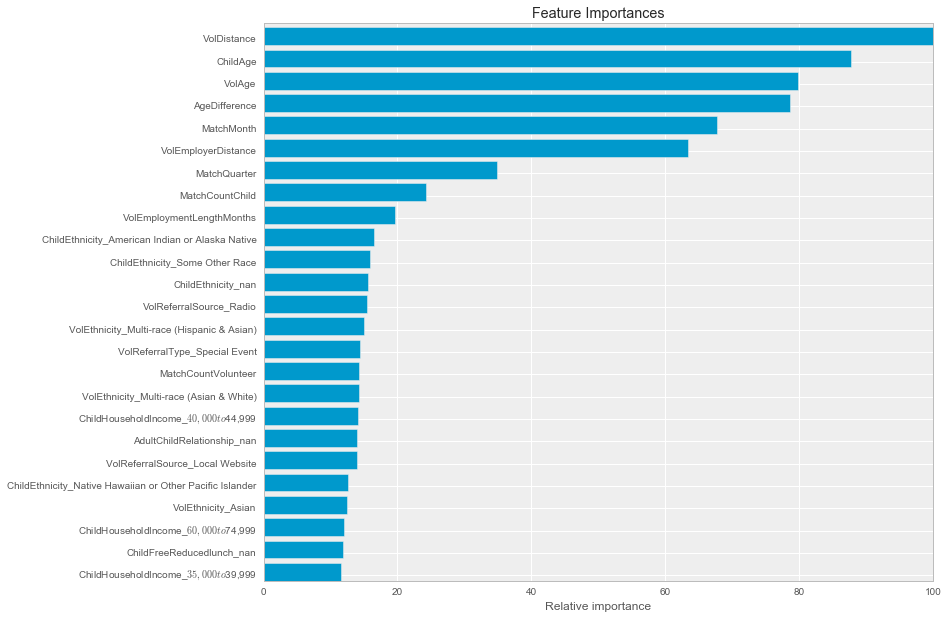

In [414]:
from sklearn.ensemble import partial_dependence as pdd
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier

# instantiate model
clf = RandomForestClassifier(n_estimators= 250, 
                             n_jobs=-1, 
                             criterion = 'gini',
                             max_features = 'auto',
                             class_weight='auto', 
                             random_state=1)

# fit model
clf.fit(X, y)

def feature_importance_viz(X_train, clf, col_names, top_n):
    # make importances relative to max importance
    importances = clf.feature_importances_
    importances = 100.0 * (importances / importances.max())
    # sort importances
    indices = np.argsort(importances)[-top_n:]
    # plot as bar chart
    plt.figure(figsize=(12, 10))
    plt.barh(np.arange(len(col_names))[:top_n], importances[indices], color='#0099CC')
    plt.yticks(np.arange(len(col_names))[:top_n] + 0.25, np.array(col_names)[indices])
    plt.xlabel('Relative importance')
    plt.title('Feature Importances')
    plt.show()

    #fig, axs = pd.plot_partial_dependence(clf, 
    #                                      X_train, 
    #                                      cols, 
    #                                      feature_names=np.array(col_names)[indices])

feature_importance_viz(X_train, clf, cols, 25)

In [415]:
# fit model
clf.fit(X_train, y_train)

# get columns
cols = df.ix[:,1:].columns.tolist()

# make predictions
clf_score = clf.score(X_test, y_test)
clf_preds= clf.predict(X_test)
try:
    clf_probs = clf.predict_proba(X_test)[:,1]
    clf_probs_2 = clf.predict_proba(X)[:,1]
    clf_probs_out = clf.predict_proba(X_new)[:,1]
except:
    pass

accuracy = 0.629044394281
brier = 0.228323659895
             precision    recall  f1-score   support

          0       0.56      0.31      0.40       529
          1       0.65      0.84      0.73       800

avg / total       0.61      0.63      0.60      1329



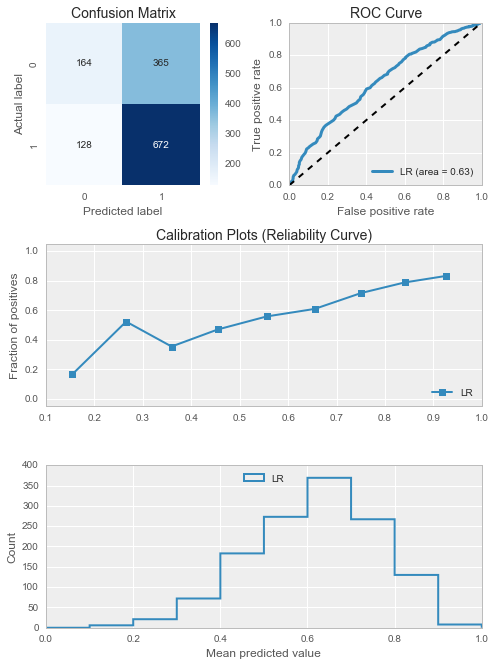

In [416]:
def clf_eval_viz(clf_name, y_test, clf_preds, clf_probs):
    
    # generate classification report
    print("accuracy = " + str(metrics.accuracy_score(y_test, clf_preds, normalize=True)))
    #clf_preds_2 = pd.Series(clf_probs).map(lambda r: 0 if r < 0.50 else 1)
    #print("recall = " + str(metrics.recall_score(y_test, clf_preds_2, pos_label=1, average='binary')))
    print("brier = " + str(metrics.brier_score_loss(y_test, clf_probs, pos_label=y.max())))
    print(metrics.classification_report(y_test, clf_preds))
    
    # create subplot
    plt.figure(figsize=(7, 12))
    ax1 = plt.subplot2grid((4,4), (0,0), colspan=2)
    ax2 = plt.subplot2grid((4,4), (0,2), colspan=2)
    ax3 = plt.subplot2grid((4,4), (1, 0), colspan=4)
    ax4 = plt.subplot2grid((4,4), (2, 0), colspan=4)
    
    # create confusion matrix
    ax1.set_title("Confusion Matrix", fontsize=14)
    cm = metrics.confusion_matrix(y_test, clf_preds)
    heatmap(cm, annot=True, fmt='', cmap='Blues', ax=ax1)
    ax1.set_xlabel('Predicted label')
    ax1.set_ylabel('Actual label')
    
    # create roc curve
    ax2.set_title("ROC Curve", fontsize=14)
    fpr, tpr, _ = metrics.roc_curve(y_test, clf_probs)
    area = metrics.auc(fpr, tpr)
    ax2.plot(fpr, tpr, label=clf_name+' (area = %0.2f)' % area, linewidth=3)
    ax2.plot([0, 1], [0, 1], 'k--')
    ax2.set_xlabel('False positive rate')
    ax2.set_ylabel('True positive rate')
    ax2.legend(loc="lower right")
    
    # calculate fraction of positives and mean predicted value
    fop, mpv = calibration_curve(y_test, clf_probs, n_bins=10)
    
    # create calibration plot 1
    ax3.plot(mpv, fop, "s-", label="%s" % (clf_name, ))
    ax3.set_ylabel("Fraction of positives")
    ax3.set_ylim([-0.05, 1.05])
    ax3.legend(loc="lower right")
    ax3.set_title('Calibration Plots (Reliability Curve)', fontsize=14)

    # create calibration plot 2
    ax4.hist(clf_probs, range=(0, 1), bins=10, label=clf_name, histtype="step", lw=2)
    ax4.set_xlabel("Mean predicted value")
    ax4.set_ylabel("Count")
    ax4.legend(loc="upper center", ncol=2)
    
    # format subplot
    plt.tight_layout()
    
clf_eval_viz('LR', y_test, clf_preds, clf_probs)

In [484]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor

del df['MatchClosureType']
df.head()

clf = GradientBoostingRegressor(loss='ls', 
                                learning_rate=0.1, 
                                n_estimators=100, 
                                subsample=1.0, 
                                criterion='friedman_mse', 
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_depth=3, 
                                min_impurity_split=1e-07, 
                                init=None, 
                                random_state=None, 
                                max_features=None, 
                                alpha=0.9, 
                                verbose=0, 
                                max_leaf_nodes=None, 
                                warm_start=False, 
                                presort='auto')

# clf = ElasticNet(alpha=1.0, 
#                  l1_ratio=0.5, 
#                  fit_intercept=True, 
#                  normalize=False, 
#                  precompute=False, 
#                  max_iter=1000, 
#                  copy_X=True, 
#                  tol=0.0001, 
#                  warm_start=False, 
#                  positive=False, 
#                  random_state=None, 
#                  selection='cyclic')

clf.fit(X_train, y_train)

clf_preds = clf.predict(X_test)
r2 = r2_score(y_test, clf_preds)
print r2
mae = mean_absolute_error(y_test, clf_preds)
print mae

0.44744713616
13.421827072


In [470]:
del df['MatchClosureType']
df.head()

,MatchLength,CouplesMatch,MatchCountChild,MatchCountVolunteer,ChildGender,ChildEthnicity,ChildAge,IncarceratedParent,AdultChildRelationship,ChildLivingSituation,ChildHouseholdIncome,ChildFreeReducedlunch,ChildReferralType,VolGender,VolEthnicity,VolAge,VolMaritalStatus,VolEmploymentLengthMonths,VolReferralSource,VolReferralType,AgeDifference,VolDistance,VolEmployerDistance,MatchReportSource,MatchQuarter,MatchMonth
0,110.600,No,1,1,M,Black,19,Unknown,Mother,Other/Unknown,Unknown,No,Self,M,Hispanic,35,Single,nan,Not Top 10,Self,16,5.415,10.374,Not Top 10,3,9
1,36.100,No,2,2,M,Black,16,Yes,Mother,Other/Unknown,Unknown,Yes,Self,M,White,43,Married,0.000,Not Top 10,Self,27,4.203,nan,Not Top 10,2,4
2,34.400,No,2,2,M,Black,18,Unknown,Mother,Other/Unknown,Unknown,No,Self,M,White,44,Married,0.000,Not Top 10,Self,26,0.000,11.331,Not Top 10,2,6
3,122.800,No,1,1,M,Black,19,No,Mother,Other/Unknown,Unknown,Yes,Self,M,White,34,Single,0.000,Not Top 10,Self,15,4.665,4.347,ACES Program,2,6
4,3.400,No,5,1,F,Black,15,Unknown,Mother,Other/Unknown,Unknown,Yes,Self,F,White,23,Single,0.000,Other,Workplace Partner,8,4.867,nan,ACES Program,3,9
